In [2]:
import torch
import torch.nn as nn
from torch.nn import init
from torch.autograd import Variable
import torchvision
import torchvision.transforms as T
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.utils.data.sampler import SubsetRandomSampler, RandomSampler
import torchvision.models as models
import torch.backends.cudnn as cudnn
from torch.optim.lr_scheduler import MultiStepLR
#torch.multiprocessing.set_start_method("spawn")
import resnet 

import numpy as np
import pandas as pd
from utils import progress_bar

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
BASE_dir = 'data/processed/'

train = pd.read_json(BASE_dir + 'train.json')
test = pd.read_json(BASE_dir + 'test.json')

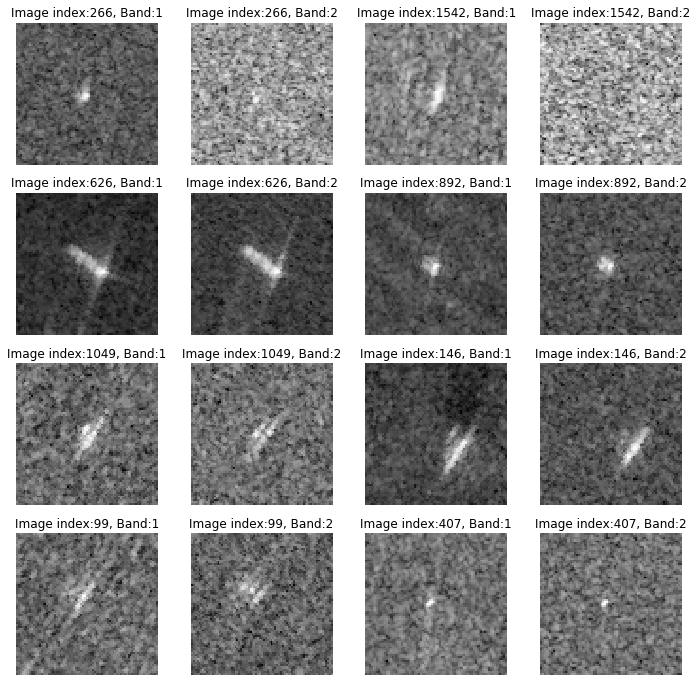

In [4]:
len(train) # 1604 obs
train.head(3)
#randomly draw some of them

fig = plt.figure(figsize=(12,12))
gs = gridspec.GridSpec(4,4)

index = np.random.choice(list(range(len(train))),size=8, replace=False)
for num,i in enumerate(index):
    for j in range(2):
        ax = plt.subplot(gs[num*2+j])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_title('Image index:%d, Band:%d' % (i, j%2+1))
        ax.set_aspect('equal')
        plt.imshow(np.array(train.iloc[i,j%2]).reshape(75,75))

In [6]:
#prepare data
use_cuda= True if torch.cuda.is_available() else False
#use_cuda =False
#dtype = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor 
dtype = torch.FloatTensor 
data=  pd.read_json(BASE_dir + 'train.json')

class iceberg_dataset(Dataset):
    def __init__(self, data, label, transform=None): #data: 1604 * 3 *75* 75
        self.data =data
        self.label = torch.from_numpy(label).type(torch.LongTensor)
        self.transform= transform
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self,idx):
        img, label=  self.data[idx], self.label[idx]
        if self.transform is not None:
            #Random Horizontal Flip and Vertical Flip 
            #https://discuss.pytorch.org/t/torch-from-numpy-not-support-negative-strides/3663
            if np.random.uniform()>0.5:
                img = np.flip(img,axis=1).copy()
            if np.random.uniform()>0.5:
                img = np.flip(img,axis=2).copy()
            img = torch.from_numpy(img).type(dtype)
            img = self.transform(img)

        return img, label

def stack(row):
    return np.stack(row[['c1','c2','c3']]).reshape(3,75,75)

def raw_to_numpy(data):
    img = []
    data['c1'] = data['band_1'].apply(np.array)
    data['c2'] = data['band_2'].apply(np.array)
    data['c3'] = (data['c1'] + data['c2'])/2
    for _, row in data.iterrows():
        img.append(stack(row))
    return np.stack(img)

def transform_compute(img):
    train_mean = img.mean(axis=(0,2,3))
    train_std = img.std(axis=(0,2,3))
    return train_mean, train_std

train_X = raw_to_numpy(data)#.transpose(0,2,3,1)
train_X.shape     #1604 * 3 *75* 75   N*c*H*W
train_y = data['is_iceberg'].values # if iceberg then 1

In [8]:
train_index=list(range(1300)) 
val_index= list(range(1300,1604))
train_X[train_index].shape

train_mean, train_std = transform_compute(train_X[train_index])
train_transform = T.Compose([
    T.Normalize(train_mean, train_std)
])

train_dataset = iceberg_dataset(data= train_X[train_index], label=train_y[train_index], transform=train_transform)
val_dataset = iceberg_dataset(data= train_X[val_index], label=train_y[val_index], transform=train_transform)

train_loader = DataLoader(train_dataset, batch_size = 64, num_workers=3, 
                          shuffle=True)
val_loader = DataLoader(val_dataset, batch_size = 64, num_workers=3)

In [25]:
torch.cuda.is_available()
torch.from_numpy(train_X).type(torch.FloatTensor)[1].shape
train_X[1]
use_cuda

True

In [33]:
resnet101 = resnet.resnet101(num_classes=2)

criterion = nn.CrossEntropyLoss()

#Adam does not perform so good here
optimizer = optim.SGD(resnet101.parameters(), lr=0.1, momentum=0.9, weight_decay=2e-3, nesterov= True)
scheduler = MultiStepLR(optimizer, [80,120,160,200], gamma=0.1)
#5e-3 86
if use_cuda:
    criterion.cuda()
    resnet101.cuda()
#     resnet101 = torch.nn.DataParallel(resnet101, device_ids=range(torch.cuda.device_count()))
#     cudnn.benchmark = True   

In [34]:
net= resnet101
def train(epoch):
    global train_data,out,y,predicted
    best_acc =0
    loss_hist = []
    train_acc_hist = []
    val_acc_hist = []
    train_data={}
    train_data['loss_hist'] = loss_hist
    train_data['train_acc_hist'] = train_acc_hist
    train_data['val_acc_hist'] =  val_acc_hist

    for i in range(epoch):
        print('\nThis is epoch:{}'.format(i+1))
        total= 0
        correct=0
        scheduler.step()
        net.train()
        for j,(batch_x, batch_y) in enumerate(train_loader):
            optimizer.zero_grad()
            if use_cuda:
                batch_x, batch_y = batch_x.cuda(), batch_y.cuda()
            x = Variable(batch_x)
            y = Variable(batch_y)
            out = net(x)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()
            
            _, predicted = torch.max(out.data, 1)
            total += y.size(0)
            correct += predicted.eq(y.data).cpu().sum()
            progress_bar(j, len(train_loader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
                % (loss.cpu().data[0], 100.*correct/total, correct, total))
            if j % 50==0:
                loss_hist.append(loss.cpu().data[0])
            
        train_acc_hist.append(100.*correct/total)
        if i %1 == 0:
            acc = test(val_loader)
            val_acc_hist.append(acc)
            if acc >best_acc:
                best_acc= acc
                torch.save(net.state_dict(), 'resnet101.pth')
                
#         if i%50==0 and save:
#             torch.save(net.state_dict(), 'resnet50.pth')
        
def test(val_load):
    net.eval()
    total = 0
    correct = 0
    loss= 0
    for k, (val_x, val_y) in enumerate(val_load):
        if use_cuda:
            val_x, val_y = val_x.cuda(), val_y.cuda()
        x = Variable(val_x)
        y = Variable(val_y)
        out = net(x)
        loss = criterion(out, y)
        #print(out.size())
        _, predicted = torch.max(out.data, 1)
        correct += predicted.eq(y.data).cpu().sum()
        total += out.size()[0]
        progress_bar(k, len(val_load), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
                % (loss.cpu().data[0], 100.*correct/total, correct, total))
    acc =  (correct*100.0)/total
    return acc

train( epoch=220)


This is epoch:1
[=================== 21/21 ================>..]  Step: 360ms | Tot: 10s30ms | Loss: 0.553 | Acc: 60.692% (789/1300)
[=================== 5/5 ============>........]  Step: 112ms | Tot: 523ms | Loss: 0.147 | Acc: 65.132% (198/304)56))

This is epoch:2
[=================== 21/21 ================>..]  Step: 357ms | Tot: 9s983ms | Loss: 0.605 | Acc: 64.769% (842/1300)
[=================== 5/5 ============>........]  Step: 112ms | Tot: 528ms | Loss: 0.774 | Acc: 49.671% (151/304)

This is epoch:3
[=================== 21/21 ================>..]  Step: 362ms | Tot: 10s14ms | Loss: 0.678 | Acc: 63.923% (831/1300)
[=================== 5/5 ============>........]  Step: 113ms | Tot: 524ms | Loss: 1.074 | Acc: 42.434% (129/304)

This is epoch:4
[=================== 21/21 ================>..]  Step: 359ms | Tot: 10s14ms | Loss: 0.537 | Acc: 66.077% (859/1300)
[=================== 5/5 ============>........]  Step: 112ms | Tot: 523ms | Loss: 0.860 | Acc: 44.079% (134/304)

This is epo

[=================== 21/21 ================>..]  Step: 361ms | Tot: 9s957ms | Loss: 0.240 | Acc: 89.308% (1161/1300)
[=================== 5/5 ============>........]  Step: 115ms | Tot: 530ms | Loss: 2.161 | Acc: 48.355% (147/304)

This is epoch:68
[=================== 21/21 ================>..]  Step: 357ms | Tot: 9s943ms | Loss: 0.232 | Acc: 87.308% (1135/1300)
[=================== 5/5 ============>........]  Step: 112ms | Tot: 527ms | Loss: 0.685 | Acc: 82.895% (252/304)

This is epoch:69
[=================== 21/21 ================>..]  Step: 358ms | Tot: 9s987ms | Loss: 0.421 | Acc: 88.385% (1149/1300)
[=================== 5/5 ============>........]  Step: 113ms | Tot: 525ms | Loss: 2.307 | Acc: 48.355% (147/304)

This is epoch:70
[=================== 21/21 ================>..]  Step: 362ms | Tot: 9s942ms | Loss: 0.328 | Acc: 89.077% (1158/1300)
[=================== 5/5 ============>........]  Step: 113ms | Tot: 523ms | Loss: 0.903 | Acc: 78.947% (240/304)

This is epoch:71
[=======

[=================== 5/5 ============>........]  Step: 113ms | Tot: 526ms | Loss: 0.582 | Acc: 90.789% (276/304)

This is epoch:133
[=================== 21/21 ================>..]  Step: 358ms | Tot: 10s9ms | Loss: 0.023 | Acc: 98.385% (1279/1300))
[=================== 5/5 ============>........]  Step: 113ms | Tot: 526ms | Loss: 0.561 | Acc: 90.132% (274/304)

This is epoch:134
[=================== 21/21 ================>..]  Step: 356ms | Tot: 10s8ms | Loss: 0.020 | Acc: 98.692% (1283/1300))
[=================== 5/5 ============>........]  Step: 112ms | Tot: 526ms | Loss: 0.627 | Acc: 90.132% (274/304)

This is epoch:135
[=================== 21/21 ================>..]  Step: 364ms | Tot: 10s24ms | Loss: 0.025 | Acc: 98.000% (1274/1300)
[=================== 5/5 ============>........]  Step: 113ms | Tot: 525ms | Loss: 0.622 | Acc: 90.132% (274/304)

This is epoch:136
[=================== 21/21 ================>..]  Step: 357ms | Tot: 9s970ms | Loss: 0.021 | Acc: 98.538% (1281/1300)
[===

[=================== 5/5 ============>........]  Step: 112ms | Tot: 523ms | Loss: 0.642 | Acc: 90.461% (275/304)

This is epoch:198
[=================== 21/21 ================>..]  Step: 362ms | Tot: 10s29ms | Loss: 0.013 | Acc: 99.077% (1288/1300)
[=================== 5/5 ============>........]  Step: 114ms | Tot: 524ms | Loss: 0.638 | Acc: 89.803% (273/304)

This is epoch:199
[=================== 21/21 ================>..]  Step: 359ms | Tot: 10s33ms | Loss: 0.021 | Acc: 99.385% (1292/1300)
[=================== 5/5 ============>........]  Step: 112ms | Tot: 522ms | Loss: 0.639 | Acc: 90.461% (275/304)

This is epoch:200
[=================== 21/21 ================>..]  Step: 358ms | Tot: 10s16ms | Loss: 0.229 | Acc: 99.231% (1290/1300)
[=================== 5/5 ============>........]  Step: 113ms | Tot: 524ms | Loss: 0.632 | Acc: 90.461% (275/304)

This is epoch:201
[=================== 21/21 ================>..]  Step: 358ms | Tot: 10s7ms | Loss: 0.271 | Acc: 99.000% (1287/1300))
[===

In [12]:
k = np.array([1,2,3])
print('sdsd')
torch.from_numpy(k).type(dtype)
print('sdsd')
for i,j in train_loader:
    print(i)
    print(j)
    break
type(train_dataset.label[1])

sdsd
sdsd

(0 ,0 ,.,.) = 
  -0.0529   0.0731   0.2728  ...   -0.4586  -0.2622  -0.2255
  -0.6807   0.1616   0.3258  ...    0.0725  -0.0865  -0.0535
  -0.6807  -0.0205  -0.1196  ...   -0.2997  -0.8307   0.0724
            ...               ⋱              ...            
   0.1900  -0.0860  -0.1892  ...    0.1319   0.1319   0.2721
   0.1900   0.2180   0.0729  ...    0.1894   0.0417   0.1319
   0.2456   0.3515   0.2456  ...    0.1319   0.1319  -0.2623

(0 ,1 ,.,.) = 
  -0.5798  -1.2395  -0.4661  ...   -1.0942  -2.5980  -1.0942
  -0.1524  -0.5799   0.1269  ...   -1.2404  -2.1316  -1.2404
  -0.3572  -0.1525   0.0371  ...   -0.9559  -1.2404  -0.6998
            ...               ⋱              ...            
  -0.3574  -2.3534  -1.3948  ...   -0.4672  -0.7000   0.2126
  -0.3574  -1.0935  -0.6991  ...   -1.2406  -2.5982  -0.1536
  -0.3574  -1.0935  -0.9551  ...   -1.5608  -1.3957  -0.5810

(0 ,2 ,.,.) = 
  -0.2939  -0.5013  -0.0211  ...   -0.7993  -1.3339  -0.6403
  -0.5321  -0.1476   0.2786

float

In [18]:
out1 = torch.cat((out.data,out.data),1)
out1.size()
# out
criterion(out,y.long())
type(predicted)
type(y.data)
#predicted.eq(y.data).cpu().sum()

torch.cuda.DoubleTensor

In [17]:
net = resnet.resnet101(num_classes=2)
net.load_state_dict(torch.load('resnet101.pth'))
net.cuda()

test = pd.read_json(BASE_dir + 'test.json')
test_X = raw_to_numpy(test)
test_X.shape 
fake_label = np.zeros(len(test_X))

test_dataset = iceberg_dataset(data= test_X, label=fake_label, transform=train_transform)

test_loader = DataLoader(test_dataset, batch_size = 64, num_workers=3)

prob = [] 
net.eval()
for k, (val_x, val_y) in enumerate(test_loader):
    if use_cuda:
        val_x, val_y = val_x.cuda(), val_y.cuda()
    x = Variable(val_x)
    y = Variable(val_y)
    out = net(x)
    temp = np.exp(out.cpu().data.numpy())
    ans= temp[:,1]/(temp.sum(axis=1))
    prob.append(ans)
    #print(out.size())
    progress_bar(k, len(test_loader))

[=================== 132/132 ================>]  Step: 100ms | Tot: 18s226ms


In [18]:
np.concatenate(prob).shape

(8424,)

In [21]:
sub=pd.DataFrame()
sub['id'] = test['id']
sub['is_iceberg'] = np.concatenate(prob)
sub.shape
sub.to_csv('submission.csv',index=False)